In [67]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [68]:
figure_path = '/home/em/fairness_figures/'

countries = [('us', 'FINCP', 'StatePUMA'),
             ('mexico', 'asset_index', 'municipality'),
             ('dhs/colombia', 'wealth', 'cluster'),
             ('dhs/honduras', 'wealth', 'cluster'),
             ('dhs/indonesia', 'wealth', 'cluster'),
             ('dhs/nigeria', 'wealth', 'cluster'),
             ('dhs/kenya', 'wealth', 'cluster'),
             ('dhs/philippines', 'wealth', 'cluster'),
             ('dhs/peru', 'wealth', 'cluster')]

def get_title(country):
    if country == 'us':
        return 'US'
    else:
        return country.title().split('/')[-1]

In [69]:
outlines = gpd.read_file('/data/mosaiks/shapefiles/countries.geojson')

us
mexico
dhs/colombia
dhs/honduras
dhs/indonesia
dhs/nigeria
dhs/kenya
dhs/philippines
dhs/peru


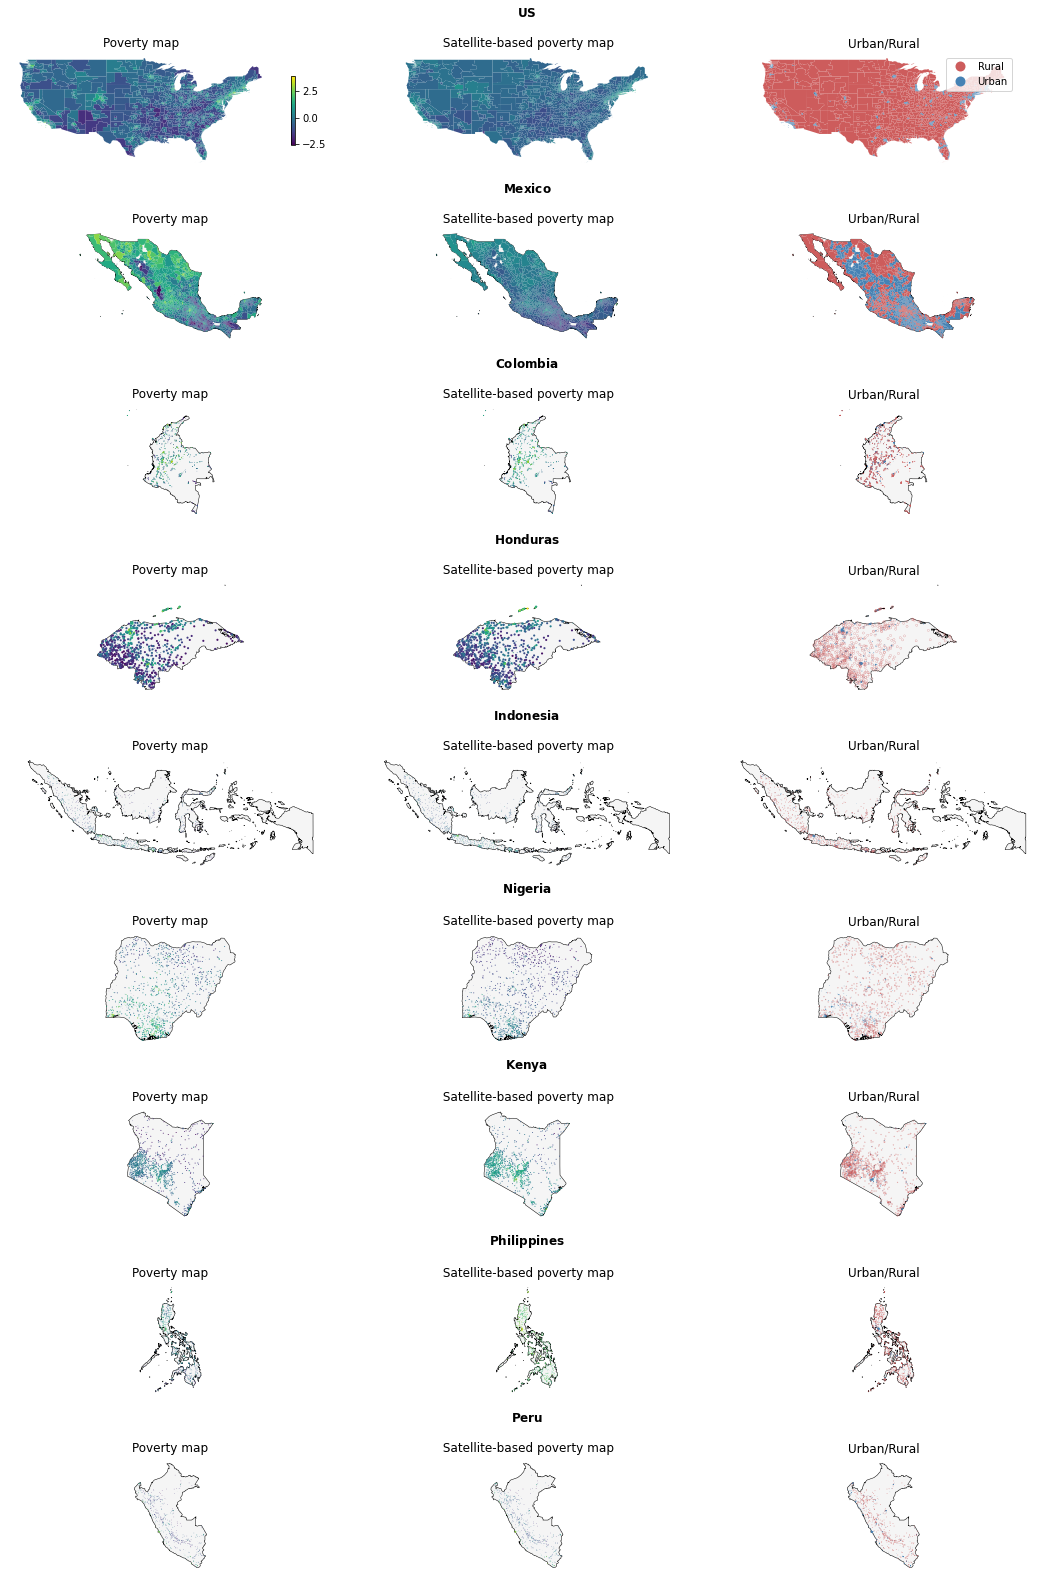

In [72]:
fig, ax = plt.subplots(len(countries), 3, figsize=(15, 22))

counter = 0
for country, poverty, key in countries:
    
    print(country)
    
    country_name = get_title(country)
    if country == 'us':
        key = ['State', 'PUMA']
    
    sims = pd.read_csv('/data/mosaiks/replication/simulations' + country + '/' + poverty + '_no_spatial.csv')
    sims = sims[sims['split'] == 'test']
    ids = pd.read_csv('/data/mosaiks/replication/simulations/' + country + '/ids.csv')
    sims = sims.merge(ids, on='Unnamed: 0', how='inner')
    sims = sims.groupby(key).agg('median')
    
    if country != 'us':
        outline = outlines[outlines['ADMIN'] == country_name]
        outline.plot(ax=ax[counter, 0], color='whitesmoke', edgecolor='black', linewidth=0.5)
        outline.plot(ax=ax[counter, 1], color='whitesmoke', edgecolor='black', linewidth=0.5)
        outline.plot(ax=ax[counter, 2], color='whitesmoke', edgecolor='black', linewidth=0.5)

    if 'us' in country:
        us = gpd.read_file('/data/mosaiks/shapefiles/us_pumas/pumas.shp')
        labels = pd.read_csv('/data/mosaiks/replication/surveys/us/groundtruth_by_puma_2019.csv')
        us = us.merge(labels, on=['State', 'PUMA'])
        us['rural'] = us['rural'].apply(lambda x: 'Rural' if x == 1 else 'Urban')
        us[poverty] = np.log(us[poverty])
        mean_pov, std_pov = us[poverty].mean(), us[poverty].std()
        us[poverty] = (us[poverty] - mean_pov)/std_pov
        us.plot(ax=ax[counter, 0], column=poverty, cmap='viridis', legend=True, legend_kwds={'shrink':0.6})
        us.plot(ax=ax[counter, 2], column='rural', cmap=ListedColormap(['indianred', 'steelblue']), legend=True)
        predictions = us.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')
        
    if 'mexico' in country:
        mexico = gpd.read_file('/data/mosaiks/shapefiles/mexico_municipalities.geojson')
        labels = pd.read_csv('/data/mosaiks/replication/surveys/mexico/grouped.csv')
        mexico = mexico.merge(labels, on='municipality', how='inner')
        mean_pov, std_pov = mexico[poverty].mean(), mexico[poverty].std()
        mexico[poverty] = (mexico[poverty] - mean_pov)/std_pov
        mexico.plot(ax=ax[counter, 0], column=poverty, cmap='viridis')
        mexico.plot(ax=ax[counter, 2], column='rural', cmap=ListedColormap(['indianred', 'steelblue']))
        predictions = mexico.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')

    if 'dhs' in country:
        clusters = gpd.read_file('/data/mosaiks/replication/surveys/dhs/' + country[4:] + '_polygons.geojson')
        labels = pd.read_csv('/data/mosaiks/replication/surveys/' + country + '_grouped.csv')
        clusters = clusters.merge(labels, on='cluster', how='inner')
        mean_pov, std_pov = clusters[poverty].mean(), clusters[poverty].std()
        clusters[poverty] = (clusters[poverty] - mean_pov)/std_pov
        clusters['area'] = clusters['geometry'].area
        urban = clusters[clusters['area'] < 0.005]
        rural = clusters[clusters['area'] > 0.005]
        clusters.plot(ax=ax[counter, 0], column=poverty)
        urban.plot(ax=ax[counter, 2], facecolor='none', edgecolor='steelblue', linewidth=0.2)
        rural.plot(ax=ax[counter, 2], facecolor='none', edgecolor='indianred', linewidth=0.2)
        predictions = clusters.merge(sims, on=key, how='inner')
        predictions.plot(ax=ax[counter, 1], column='yhat', cmap='viridis')
    
    ax[counter, 0].axis('off')
    ax[counter, 1].axis('off')
    ax[counter, 2].axis('off')
    
    ax[counter, 0].set_title('Poverty map')
    ax[counter, 1].set_title(r"$\bf{" + country_name + "}$" + '\n\n Satellite-based poverty map')
    ax[counter, 2].set_title('Urban/Rural')
    
    counter += 1

plt.tight_layout()
plt.savefig('/home/em/exporemaps.png', dpi=500)
plt.show()